In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

In [2]:
df=pd.read_csv("Food_Delivery_Time_Prediction.csv")
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [3]:
df.isnull().sum()

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

In [4]:
le1=LabelEncoder()
le2=LabelEncoder()
le3=LabelEncoder()
df["Weather_Conditions"]=le1.fit_transform(df["Weather_Conditions"])
df["Traffic_Conditions"]=le2.fit_transform(df["Traffic_Conditions"])
df["Order_Priority"]=le3.fit_transform(df["Order_Priority"])

In [5]:
scaler=MinMaxScaler()
df[["Distance","Delivery_Time"]]=scaler.fit_transform(df[["Distance","Delivery_Time"]])

In [6]:
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",0.043068,1,2,4,2,Afternoon,Car,4.1,3.0,0.105228,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",0.853158,0,2,8,1,Night,Car,4.5,4.2,0.453658,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",0.263741,2,2,9,0,Night,Bike,3.3,3.4,0.317886,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0.544299,0,1,2,2,Evening,Bike,3.2,3.7,0.923018,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",0.254307,1,0,6,1,Night,Bike,3.5,2.8,0.164209,619.81,2.34


In [7]:
high_traffic_count = (
    df[df['Traffic_Conditions'] == 2]
    .groupby('Order_Time')
    .size()
    .sort_values(ascending=False)
)
top_rush_times = high_traffic_count.head(2).index.tolist()
df['Rush_Hour'] = df['Order_Time'].apply(lambda x: 1 if x in top_rush_times else 0)
print("Rush hour time slots based on high traffic:\n", top_rush_times)
print(df[['Order_Time', 'Traffic_Conditions', 'Rush_Hour']].head())

Rush hour time slots based on high traffic:
 ['Evening', 'Night']
  Order_Time  Traffic_Conditions  Rush_Hour
0  Afternoon                   2          0
1      Night                   2          1
2      Night                   2          1
3    Evening                   1          1
4      Night                   0          1


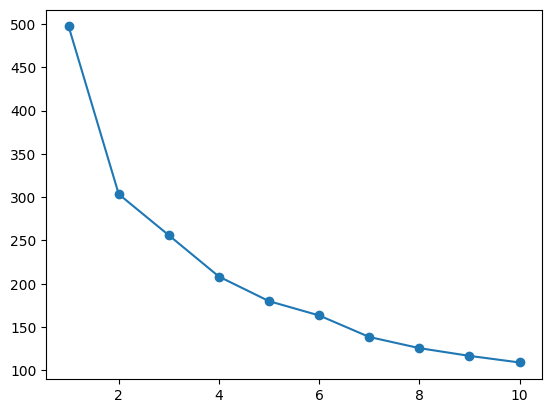

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
X=df[["Weather_Conditions","Traffic_Conditions","Order_Priority","Distance"]]
interias=[]
k_range=range(1,11)
for k in k_range:
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(X)
    interias.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(k_range,interias,marker="o")
plt.show()



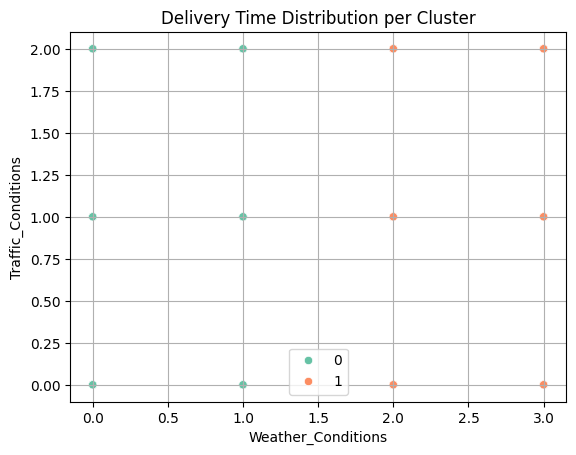

In [28]:
kmeans=KMeans(n_clusters=2,random_state=42)
kmeans_labels = kmeans.fit_predict(X)
df['KMeans_Cluster'] = kmeans_labels
import seaborn as sns
sns.scatterplot(x="Weather_Conditions", y="Traffic_Conditions",hue=kmeans_labels,data=df, palette="Set2")
plt.title("Delivery Time Distribution per Cluster")
plt.grid(True)
plt.show()

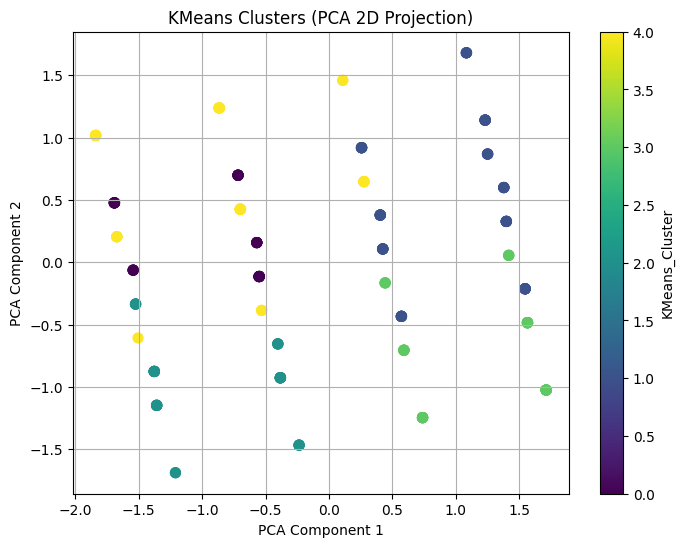

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["KMeans_Cluster"], cmap='viridis', s=50)
plt.title("KMeans Clusters (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="KMeans_Cluster")
plt.grid(True)
plt.show()

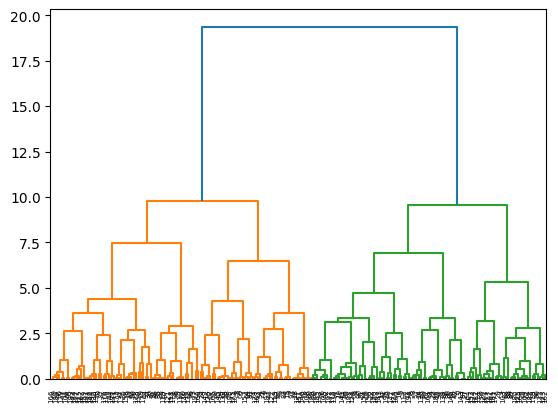

In [16]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
linked = linkage(X, method='ward')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.show()

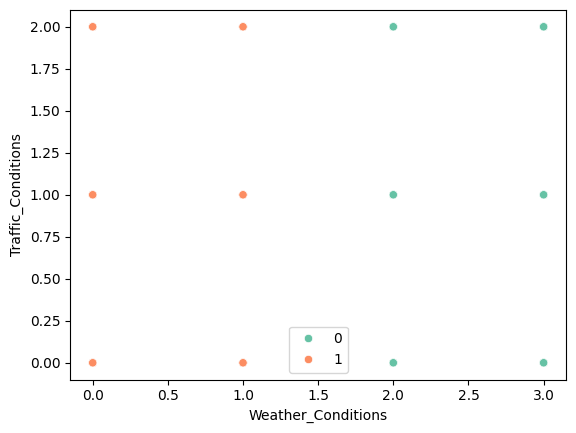

In [25]:
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg_labels = agg.fit_predict(X)
df['Agglo_Cluster'] = agg_labels
sns.scatterplot(x="Weather_Conditions", y="Traffic_Conditions", hue=agg_labels,data=df, palette='Set2')
plt.show()

In [30]:
mean_time = df['Delivery_Time'].mean()
df['Status'] = df['Delivery_Time'].apply(lambda x: 0 if x < mean_time else 1)
y=df["Status"]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
classifier=Sequential()
classifier.add(Dense(32,input_dim=X_train.shape[1],activation="relu"))
classifier.add(Dense(16,activation="relu"))
classifier.add(Dense(1,activation="sigmoid"))
classifier.compile(optimizer='adam',
    loss="binary_crossentropy",
    metrics=["accuracy"]),

C:\Users\Dell\tf_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(None,)

In [47]:
history=classifier.fit(X_train,y_train,epochs=10,batch_size=16,validation_data=(X_test,y_test))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7233 - loss: 0.5821 - val_accuracy: 0.5500 - val_loss: 0.6346
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7155 - loss: 0.5805 - val_accuracy: 0.5500 - val_loss: 0.6366
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6631 - loss: 0.5870 - val_accuracy: 0.5500 - val_loss: 0.6447
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6902 - loss: 0.5964 - val_accuracy: 0.5750 - val_loss: 0.6350
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6916 - loss: 0.5478 - val_accuracy: 0.5500 - val_loss: 0.6372
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6681 - loss: 0.5781 - val_accuracy: 0.5500 - val_loss: 0.6401
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7009 - loss: 0.5618 - val_accuracy: 0.5500 - val_loss: 0.6382
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6781 - loss: 0.5791 - val_accuracy: 0.5500 - v

In [49]:
y_pred_probs= classifier.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
              precision    recall  f1-score   support

           0       0.48      0.56      0.51        18
           1       0.58      0.50      0.54        22

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.53        40



In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predicted probabilities to binary
y_pred_nn = (classifier.predict(X_test) > 0.5).astype(int)

# Evaluation
print("🔍 Neural Network Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))
print("F1-score:", f1_score(y_test, y_pred_nn))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
🔍 Neural Network Evaluation
Accuracy: 0.525
Precision: 0.5789473684210527
Recall: 0.5
F1-score: 0.5365853658536586


In [52]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

print("🔍 Logistic Regression Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))

🔍 Logistic Regression Evaluation
Accuracy: 0.575
Precision: 0.6086956521739131
Recall: 0.6363636363636364
F1-score: 0.6222222222222222
